In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
from scipy import stats
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore warnings (from sklearn and seaborn)

import xgboost as xgb
from scipy import stats
from scipy.stats import norm, skew #for some statistics

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

# Overview of the Data

First, we read the csv dataset to train and test

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Here, we are trying to see the data in the datasets.

In [3]:
print("This is the first 5 row of the train dataset")
print(train.head(5))

This is the first 5 row of the train dataset
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL       65.000     8450   Pave   NaN      Reg   
1   2          20       RL       80.000     9600   Pave   NaN      Reg   
2   3          60       RL       68.000    11250   Pave   NaN      IR1   
3   4          70       RL       60.000     9550   Pave   NaN      IR1   
4   5          60       RL       84.000    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  Sal

In [4]:
print("This is the first 5 row of the test dataset\n")
print(test.head(5))

This is the first 5 row of the test dataset

     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH       80.000    11622   Pave   NaN      Reg   
1  1462          20       RL       81.000    14267   Pave   NaN      IR1   
2  1463          60       RL       74.000    13830   Pave   NaN      IR1   
3  1464          60       RL       78.000     9978   Pave   NaN      IR1   
4  1465         120       RL       43.000     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSol

In [5]:
# In this code, we are trying to see the overall amount of data that we have
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 


Since Id is not necessary for the prediction but important for future references, we saved the Id, but dropping the data when it comes to using it as an input for the prediction

In [6]:
#Saving the Id
train_ID = train['Id']
test_ID = test['Id']

#Dropping the ID from the prediction input
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))


The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


<AxesSubplot:>

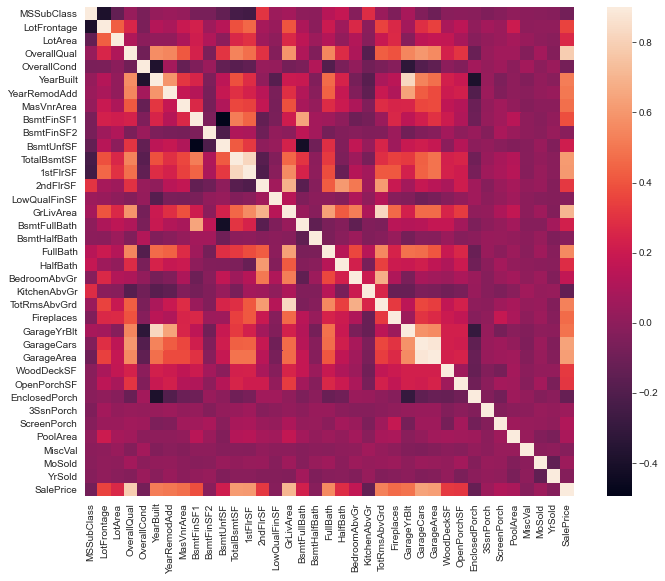

In [7]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

# Cleaning the Dataset

For cleaning the dataset, we first look at the data at each column by plotting a graph and see if...
- There are any outliers in the data. If there is then remove them.
- It looks like there is any correlation with SalesPrice. If no correlation, then drop it from the dataframe.

There are also some columns that are categorical, because of that we measure if there is any outlier or correlation with the frequency of the categories.

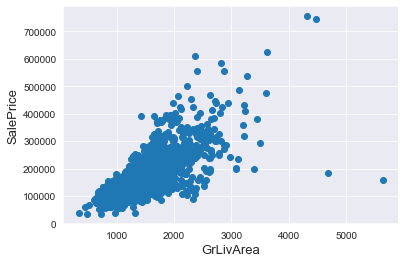

In [8]:
#First Column is GrLivArea

#Plot the data to see if there are any outliers
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

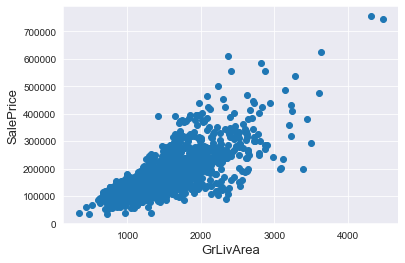

In [9]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Repeat the steps for every column.

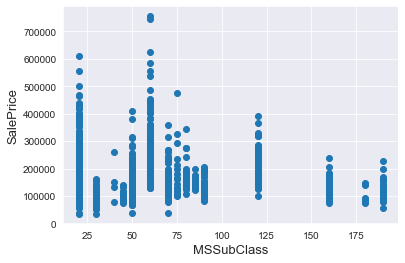

In [10]:
#MSSubClass Column

#Plotting graph
fig, ax = plt.subplots()
ax.scatter(x = train['MSSubClass'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('MSSubClass', fontsize=13)
plt.show()

In [11]:
#The data has little to no correlation to the sales
train.drop("MSSubClass", axis = 1, inplace = True)
test.drop("MSSubClass", axis = 1, inplace = True)

In [12]:
#MSZoning Column. This data is categorical, using frequency
df=pd.DataFrame({'data':train['MSZoning']})
count = df['data'].value_counts() 
print(count)

RL         1149
RM          218
FV           65
RH           16
C (all)      10
Name: data, dtype: int64


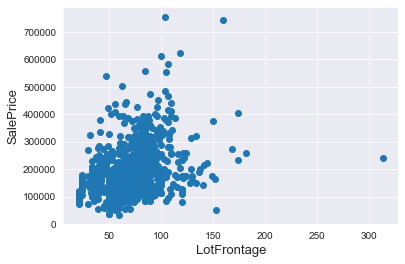

In [13]:
#LotFrontage Column

fig, ax = plt.subplots()
ax.scatter(x = train['LotFrontage'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotFrontage', fontsize=13)
plt.show()

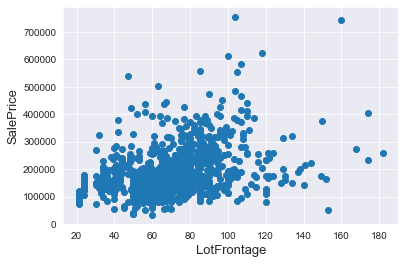

In [14]:
#Deleting Outliers
train = train.drop(train[(train['LotFrontage']>250)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['LotFrontage'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotFrontage', fontsize=13)
plt.show()

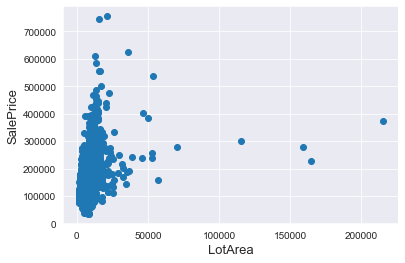

In [15]:
#LotArea Column

fig, ax = plt.subplots()
ax.scatter(x = train['LotArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotArea', fontsize=13)
plt.show()

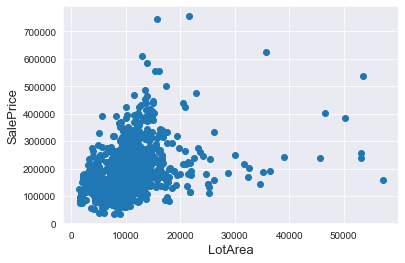

In [16]:
#Deleting Outliers
train = train.drop(train[(train['LotArea']>60000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['LotArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotArea', fontsize=13)
plt.show()

In [17]:
#Street Column. This data is categorical, using frequency

df=pd.DataFrame({'data':train['Street']})
count = df['data'].value_counts() 
print(count)

# Drop this column, too little information 
train.drop("Street", axis = 1, inplace = True)
test.drop("Street", axis = 1, inplace = True)

Pave    1447
Grvl       5
Name: data, dtype: int64


In [18]:
#Alley Column. This data is categorical, using frequency

df=pd.DataFrame({'data':train['Alley']})
count = df['data'].value_counts() 
print(count)

Grvl    50
Pave    41
Name: data, dtype: int64


In [19]:
#LotShape Column. This data is categorical, using frequency

df=pd.DataFrame({'data':train['LotShape']})
count = df['data'].value_counts() 
print(count)

Reg    925
IR1    481
IR2     38
IR3      8
Name: data, dtype: int64


In [20]:
#LandContour Column. This data is categorial, using frequency

df=pd.DataFrame({'data':train['LandContour']})
count = df['data'].value_counts() 
print(count)

Lvl    1311
Bnk      61
HLS      48
Low      32
Name: data, dtype: int64


In [21]:
#Utilities Column. This data is categorical, using frequency
df=pd.DataFrame({'data':train['Utilities']})
count = df['data'].value_counts() 
print(count)

# Drop this column, too little information 
train.drop("Utilities", axis = 1, inplace = True)
test.drop("Utilities", axis = 1, inplace = True)

AllPub    1451
NoSeWa       1
Name: data, dtype: int64


In [22]:
#LotConfig Column. This data is categorical, using frequency.

df=pd.DataFrame({'data':train['LotConfig']})
count = df['data'].value_counts() 
print(count)

Inside     1048
Corner      261
CulDSac      92
FR2          47
FR3           4
Name: data, dtype: int64


In [23]:
# Drop data.
train = train.drop(train[(train['LotConfig']=="FR3")].index)

df=pd.DataFrame({'data':train['LotConfig']})
count = df['data'].value_counts() 
print(count)

Inside     1048
Corner      261
CulDSac      92
FR2          47
Name: data, dtype: int64


In [24]:
#LandSlope Column. Categorical Data.

df=pd.DataFrame({'data':train['LandSlope']})
count = df['data'].value_counts() 
print(count)

Gtl    1376
Mod      63
Sev       9
Name: data, dtype: int64


In [25]:
#Neighbourhood Column. Categorical Data.

df=pd.DataFrame({'data':train['Neighborhood']})
count = df['data'].value_counts() 
print(count)

NAmes      224
CollgCr    150
OldTown    113
Edwards     98
Somerst     85
Gilbert     79
NridgHt     75
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     57
Crawfor     51
Mitchel     49
NoRidge     41
IDOTRR      37
Timber      36
SWISU       25
StoneBr     25
ClearCr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: data, dtype: int64


In [26]:
#Condition1 Column. Categorical Data.

df=pd.DataFrame({'data':train['Condition1']})
count = df['data'].value_counts() 
print(count)

Norm      1252
Feedr       80
Artery      48
RRAn        26
PosN        18
RRAe        11
PosA         7
RRNn         4
RRNe         2
Name: data, dtype: int64


In [27]:
train = train.drop(train[(train['Condition1']=="RRNn") | (train['Condition1']=="RRNe")].index)

df=pd.DataFrame({'data':train['Condition1']})
count = df['data'].value_counts() 
print(count)

Norm      1252
Feedr       80
Artery      48
RRAn        26
PosN        18
RRAe        11
PosA         7
Name: data, dtype: int64


In [28]:
#BldgType Column. Categorical Data.

df=pd.DataFrame({'data':train['BldgType']})
count = df['data'].value_counts() 
print(count)

1Fam      1206
TwnhsE     112
Duplex      51
Twnhs       43
2fmCon      30
Name: data, dtype: int64


In [29]:
#HouseStyle Column. Categorical Data.

df=pd.DataFrame({'data':train['HouseStyle']})
count = df['data'].value_counts() 
print(count)

1Story    717
2Story    438
1.5Fin    152
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: data, dtype: int64


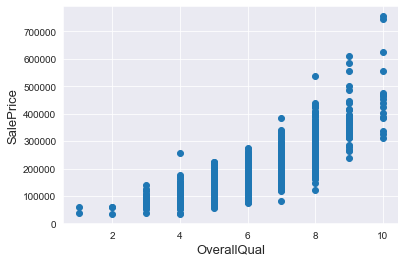

In [30]:
#OverallQual Column

fig, ax = plt.subplots()
ax.scatter(x = train['OverallQual'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallQual', fontsize=13)
plt.show()

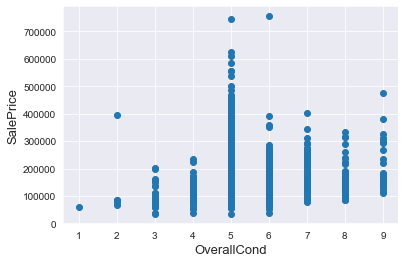

In [31]:
#OverallCond Column

fig, ax = plt.subplots()
ax.scatter(x = train['OverallCond'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallCond', fontsize=13)
plt.show()

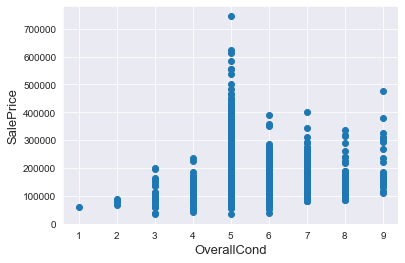

In [32]:
#Deleting Outlier
train = train.drop(train[(train['OverallCond']==2) & (train['SalePrice']>300000)].index)
train = train.drop(train[(train['OverallCond']==6) & (train['SalePrice']>600000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['OverallCond'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallCond', fontsize=13)
plt.show()

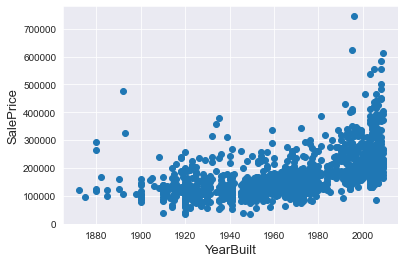

In [33]:
#YearBuilt Column

fig, ax = plt.subplots()
ax.scatter(train['YearBuilt'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('YearBuilt', fontsize=13)
plt.show()

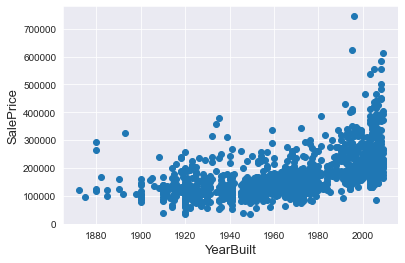

In [34]:
#Remove outlier
train = train.drop(train[(train['YearBuilt']<1900) & (train['SalePrice']>400000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['YearBuilt'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('YearBuilt', fontsize=13)
plt.show()

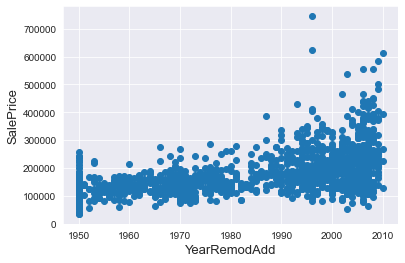

In [35]:
#YearRemodAdd Column

fig, ax = plt.subplots()
ax.scatter(train['YearRemodAdd'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('YearRemodAdd', fontsize=13)
plt.show()

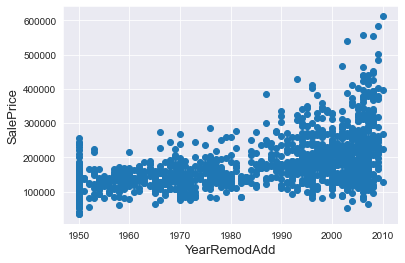

In [36]:
#Remove outlier
train = train.drop(train[(train['YearRemodAdd']<2000) & (train['SalePrice']>600000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['YearRemodAdd'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('YearRemodAdd', fontsize=13)
plt.show()

In [37]:
#RoofStyle Column

df=pd.DataFrame({'data':train['RoofStyle']})
count = df['data'].value_counts() 
print(count)

Gable      1129
Hip         276
Flat         12
Gambrel      11
Mansard       7
Shed          2
Name: data, dtype: int64


In [38]:
#RoofMatl Colunm

df=pd.DataFrame({'data':train['RoofMatl']})
count = df['data'].value_counts() 
print(count)


#Remove outliers
train = train.drop(train[(train['RoofMatl']=="Metal") | (train['RoofMatl']=="Roll") | (train['RoofMatl']=="Membran") ].index)


CompShg    1416
Tar&Grv      10
WdShake       5
WdShngl       3
Roll          1
Membran       1
Metal         1
Name: data, dtype: int64


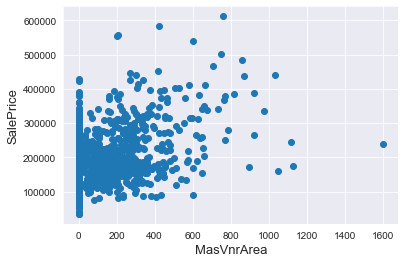

In [39]:
#MasVnr Area Column

fig, ax = plt.subplots()
ax.scatter(train['MasVnrArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('MasVnrArea', fontsize=13)
plt.show()

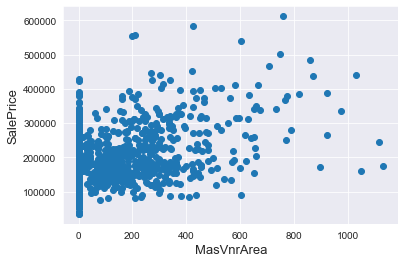

In [40]:
#Remove outlier
train = train.drop(train[(train['MasVnrArea']>1200)].index)


#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['MasVnrArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('MasVnrArea', fontsize=13)
plt.show()

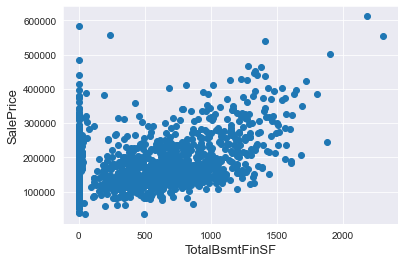

In [41]:
#BsmtFinSF2 column
# combine BsmtFinSF2 and BsmtFinSF1 together.

train['TotalBsmtFinSF'] = train['BsmtFinSF2'] + train['BsmtFinSF1']
test['TotalBsmtFinSF'] = test['BsmtFinSF2'] + test['BsmtFinSF1']

train.drop("BsmtFinSF2", axis = 1, inplace = True)
train.drop("BsmtFinSF1", axis = 1, inplace = True)
test.drop("BsmtFinSF2", axis = 1, inplace = True)
test.drop("BsmtFinSF1", axis = 1, inplace = True)


fig, ax = plt.subplots()
ax.scatter(train['TotalBsmtFinSF'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotalBsmtFinSF', fontsize=13)
plt.show()

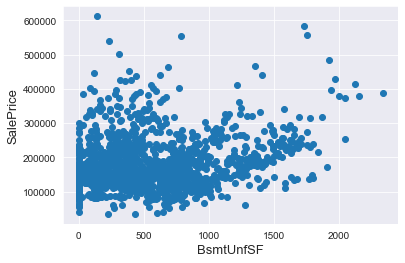

In [42]:
#BsmitUnfSF Column

fig, ax = plt.subplots()
ax.scatter(train['BsmtUnfSF'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('BsmtUnfSF', fontsize=13)
plt.show()

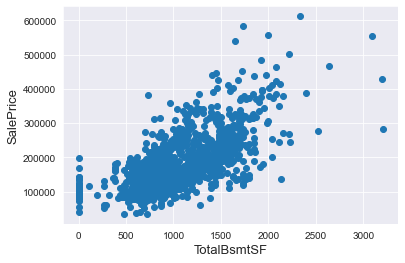

In [43]:
#TotalBsmtSF Column

fig, ax = plt.subplots()
ax.scatter(train['TotalBsmtSF'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotalBsmtSF', fontsize=13)
plt.show()

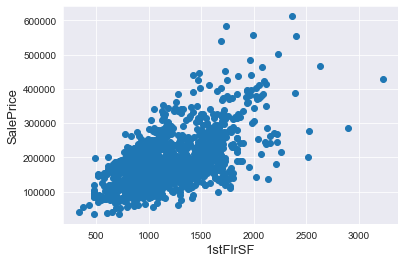

In [44]:
#1stFlrSF Column

fig, ax = plt.subplots()
ax.scatter(train['1stFlrSF'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('1stFlrSF', fontsize=13)
plt.show()

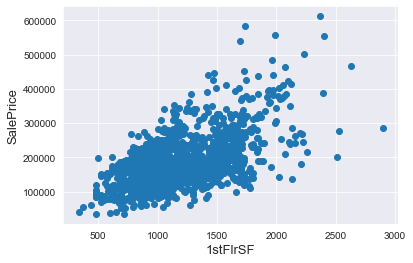

In [45]:
#remove outlier
train = train.drop(train[(train['1stFlrSF']>3000)].index)

#plotting graph
fig, ax = plt.subplots()
ax.scatter(train['1stFlrSF'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('1stFlrSF', fontsize=13)
plt.show()

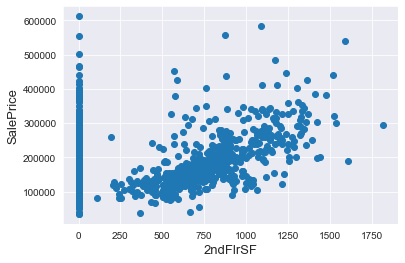

In [46]:
#2ndFlrSF Column

fig, ax = plt.subplots()
ax.scatter(train['2ndFlrSF'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('2ndFlrSF', fontsize=13)
plt.show()

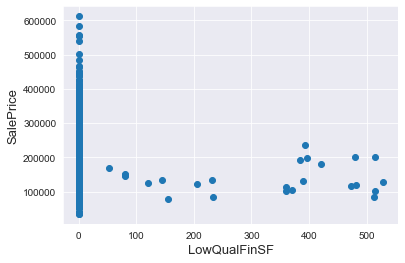

In [47]:
#LowQualFinSF Column

fig, ax = plt.subplots()
ax.scatter(train['LowQualFinSF'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LowQualFinSF', fontsize=13)
plt.show()

In [48]:
# Doesn't seem to have any correlation
train.drop("LowQualFinSF", axis = 1, inplace = True)
test.drop("LowQualFinSF", axis = 1, inplace = True)

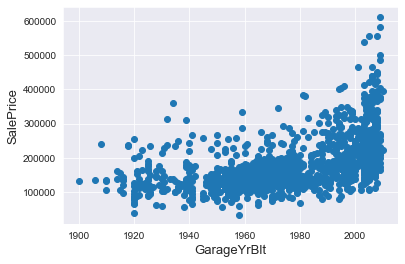

In [49]:
#GarageYrBlt Column

fig, ax = plt.subplots()
ax.scatter(train['GarageYrBlt'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GarageYrBlt', fontsize=13)
plt.show()

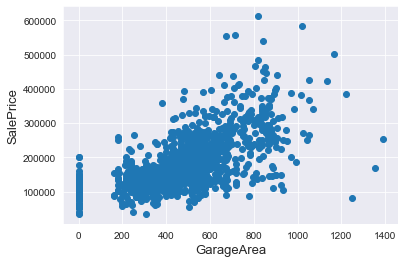

In [50]:
#GarageArea Column

fig, ax = plt.subplots()
ax.scatter(train['GarageArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GarageArea', fontsize=13)
plt.show()

train = train.drop(train[(train['GarageArea']>1200) & (train['SalePrice']<300000)].index)

In [51]:
#YrSold Column

df=pd.DataFrame({'data':train['YrSold']})
count = df['data'].value_counts() 
print(count)

2009    335
2007    319
2006    307
2008    296
2010    172
Name: data, dtype: int64


In [52]:
# Doesn't seem to have any correlation
train.drop("YrSold", axis = 1, inplace = True)
test.drop("YrSold", axis = 1, inplace = True)

Now plot the SalePrice.

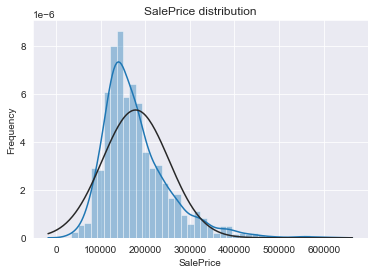

In [53]:
# Checking target variable - Analysis on sales variable 
sns.distplot(train['SalePrice'] , fit=norm);

#Now plot the distribution
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.show()

We see that the graph is right skewed, therefore we transform the data with log.

In [54]:
train["SalePrice"] = np.log1p(train["SalePrice"])

Check the graph again.

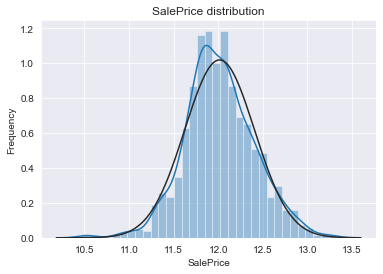

In [55]:
sns.distplot(train['SalePrice'] , fit=norm);

plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.show()

Since SalePrice is actually not what we use to predict the SalePrice, therefore we drop this column too

In [56]:
y_train = train.SalePrice.values

In [57]:
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))


The train data size after dropping Id feature is : (1429, 74) 
The test data size after dropping Id feature is : (1459, 73) 


# Filling Missing Value

In [58]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# %matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
from scipy import stats

First, we have to combine both the training and testing data together

In [59]:
all_dat = pd.concat((train, test)).reset_index(drop=True)
all_dat.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_dat.shape))

all_data size is : (2888, 73)


Next, we will see the overview of the missing data ratio

In [60]:
all_na = (all_dat.isnull().sum() / len(all_dat)) * 100 
all_na = all_na.drop(all_na[all_na == 0].index).sort_values(ascending = False)
missing_dat = pd.DataFrame({'Missing ratio':all_na})
missing_dat.head(40)

,Missing ratio
PoolQC,99.723
MiscFeature,96.468
Alley,93.179
Fence,80.332
FireplaceQu,48.927
LotFrontage,16.551
GarageFinish,5.506
GarageCond,5.506
GarageQual,5.506
GarageYrBlt,5.506


Now, we fill the missing data.

PoolQC: NA means no pool 

In [61]:
all_dat["PoolQC"] = all_dat["PoolQC"].fillna("none")

MiscFeature: Na means none 

In [62]:
all_dat["MiscFeature"] = all_dat["MiscFeature"].fillna("none")

Alley: NA means no alley access 

In [63]:
all_dat["Alley"] = all_dat["Alley"].fillna("none")

Fence: NA means no fence

In [64]:
all_dat["Fence"] = all_dat["Fence"].fillna("none")

FireplaceQu: NA means no fireplace 

In [65]:
all_dat["FireplaceQu"] = all_dat["FireplaceQu"].fillna("none")

LotFrontage: Can try to fill NA with the median of the same neighbourhood. Since the same neighbourhood tend to have the same street size 

In [66]:
all_dat["LotFrontage"] = all_dat.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)

Fill GarageFinish, GarageQual, GarageCond, GarageType with none since it means they have no garage

In [67]:
for i in ("GarageFinish", "GarageQual", "GarageCond", "GarageType"): 
    all_dat[i] = all_dat[i].fillna("none")

GarageYrBlt, GarageCars, GarageArea fill 0 for NA since there are no cars, no area. 

In [68]:
for i in ("GarageYrBlt", "GarageCars", "GarageArea"): 
    all_dat[i] = all_dat[i].fillna(0)

BsmtExposure, BsmtCond, BsmtQual, BsmtFinType1, BsmtFinType2 fill NA with none since it means no basement 

In [69]:
for i in ("BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType1", "BsmtFinType2"): 
    all_dat[i] = all_dat[i].fillna("none")

BsmtHalfBath, BsmtFullBath, TotalBsmtSF, BsmtUnfSF, BsmtFinSF2, BsmtFinSF1 values are likely to be 0 for no basement 

In [70]:
for i in ("BsmtHalfBath", "BsmtFullBath", "TotalBsmtSF", "BsmtUnfSF", "TotalBsmtFinSF"): 
    all_dat[i] = all_dat[i].fillna(0)

MasVnrType and MasVnrArea can be replaced with none and 0 respectively for no masonry

In [71]:
all_dat["MasVnrType"] = all_dat["Fence"].fillna("none")
all_dat["MasVnrArea"] = all_dat["Fence"].fillna("none")

Can try to fill NA with RL since its the most frequent data in the MSZoning 

In [72]:
all_dat["MSZoning"] = all_dat["MSZoning"].fillna("RL")

Functional: Can assume NA as typical(Typ) according to the data description

In [73]:
all_dat["Functional"] = all_dat["Functional"].fillna("Typ")

Utilities is dropped in the cleaning outlier 

In [74]:
# Already dropped so no need to do this
# all_dat = all_dat.drop(['Utilities'], axis=1) 

SaleType: Fill NA with the most frequent data

In [75]:
all_dat["SaleType"] = all_dat["SaleType"].fillna(all_dat["SaleType"].mode()[0])

KitchenQual: Fill the the most frequent data

In [76]:
all_dat["KitchenQual"] = all_dat["KitchenQual"].fillna(all_dat["KitchenQual"].mode()[0])

Electrical: Fill with the most frequent data 

In [77]:
all_dat["Electrical"] = all_dat["Electrical"].fillna(all_dat["Electrical"].mode()[0])

Same case with both Exterior1st and 2nd, fill with the most frequent data 

In [78]:
all_dat["Exterior1st"] = all_dat["Exterior1st"].fillna(all_dat["Exterior1st"].mode()[0])
all_dat["Exterior2nd"] = all_dat["Exterior2nd"].fillna(all_dat["Exterior2nd"].mode()[0])

After all the data are filled, check again to see if there are any missing data left.

In [79]:
# Check again to confirm that there is no more missing value 
all_na = (all_dat.isnull().sum() / len(all_dat)) * 100 
all_na = all_na.drop(all_na[all_na == 0].index).sort_values(ascending = False)
missing_dat = pd.DataFrame({'Missing ratio':all_na})
missing_dat.head(40)

print("\nThe all_dat data size after dropping Id feature is : {} ".format(all_dat.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))


The all_dat data size after dropping Id feature is : (2888, 73) 
The test data size after dropping Id feature is : (1459, 73) 


In [80]:
all_na = (all_dat.isnull().sum() / len(all_dat)) * 100 
all_na = all_na.drop(all_na[all_na == 0].index).sort_values(ascending = False)
missing_dat = pd.DataFrame({'Missing ratio':all_na})
missing_dat.head(40)

,Missing ratio


Filling missing value is done 

# Fixing Skew 

In this section, we will fix the skew of the data.

In [81]:
numeric = all_dat.dtypes[all_dat.dtypes != "object"].index

# Check the skew of all numerical features
skewed_features = all_dat[numeric].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkewed Numbers: \n")
skewness = pd.DataFrame({'Skew' :skewed_features})
skewness.head(60)

skewness = skewness[abs(skewness) > 0.75]
print("There are", skewness.shape[0], "skewed numbers")

print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))


Skewed Numbers: 

There are 31 skewed numbers

The train data size after dropping Id feature is : (1429, 74) 
The test data size after dropping Id feature is : (1459, 73) 


We fix the skewness with Box Cox transform

In [82]:
print("The train data size: {} ".format(train.shape))
print("The test data size after ad the missing columns: {} ".format(test.shape))

The train data size: (1429, 74) 
The test data size after ad the missing columns: (1459, 73) 


Check if there is still any skew

In [83]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for i in skewed_features:
    all_dat[i] = boxcox1p(all_dat[i], lam)
    
# Check the skewness again
skewed_features = all_dat[numeric].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_features})
skewness.head(60)

print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))


Skew in numerical features: 


The train data size after dropping Id feature is : (1429, 74) 
The test data size after dropping Id feature is : (1459, 73) 


In [84]:
# update train 
# Get dummy categorical features

all_dat = pd.get_dummies(all_dat)
n_train = train.shape[0]
n_test = test.shape[0]
train = all_dat[:n_train]
test = all_dat[n_train:]

print("\nThe all_dat data size after dropping Id feature is : {} ".format(all_dat.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))


The all_dat data size after dropping Id feature is : (2888, 295) 
The test data size after dropping Id feature is : (1459, 295) 


# Training the Model

Next, we train the model. 

In [85]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,ElasticNetCV,SGDRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from pandas import read_csv
from sklearn.model_selection import GridSearchCV
from numpy import arange
from sklearn.model_selection import RepeatedKFold
import xgboost as xgb
import lightgbm as lgb

We use k-fold cross validation 

In [86]:
## increase n_folds if model is undersetimation, vice versa
n_folds = 5

def crossval_score(model):
    kf=KFold(n_folds,shuffle = True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


Here, we define the parameters of the model

In [87]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   


In [88]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=42))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.95, random_state=42))

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4,random_state =42)

SGD = SGDRegressor(loss='huber', penalty='l1', alpha=0.0001, l1_ratio=0.95)

model_xgb = xgb.XGBRegressor(learning_rate=0.005, max_depth=3)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05,max_depth=8)

averaged_models = AveragingModels(models = (ENet, GBoost, lasso, model_lgb))


Here, we make the dictionary of functions to run

In [89]:
dict_models = {
    "lasso": lasso,
    "ENet": ENet,
    "GBoost": GBoost,
    "SGD":SGD,
    "LGB": model_lgb,
    "XGB": model_xgb,
    "AVG model": averaged_models
}

Runs the model, check with rmsle, use crossval, and then send it to the csv.

In [90]:
def modelpredcsv(model, csvname):
    model.fit(train, y_train)

    model_train_pred = model.predict(train)
    model_pred = np.expm1(model.predict(test))
    
    print("RMSLE:",rmsle(y_train, model_train_pred))
    cv_score = crossval_score(model)
    print("Crossval RMSE:",cv_score.mean(),",", cv_score.std())
    print("----------------")
    
    submission = pd.DataFrame()
    submission['Id'] = test_ID
    submission['SalePrice'] = model_pred
    csvdir = "resultscsv\\" + csvname +".csv"
    submission.to_csv(csvdir,index=False)

In [91]:
Run the function above for multiple models.

SyntaxError: invalid syntax (<ipython-input-91-84f3eeb37d08>, line 1)

In [ ]:
for modelname in dict_models:
    print(modelname)
    currmodel = dict_models.get(modelname)
    modelpredcsv(currmodel, modelname)